In [2]:
#importing all the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression

In [6]:
#Load and inspect the data 
df = pd.read_csv('car_data_v2.csv')
print("Data loaded successfully!")
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")  
df.head()

Data loaded successfully!
Dataset shape: (2119, 9)

First 5 rows:


,car_name,brand,model,vehicle_age,km_driven,mileage,max_power,seats,selling_price
0,Maruti Alto,Maruti,Alto,9,120000,19.70,46.30,5,120000
1,Maruti Alto,Maruti,Alto,9,37000,20.92,67.10,5,226000
2,Maruti Wagon R,Maruti,Wagon R,8,35000,18.90,67.10,5,350000
3,Maruti Wagon R,Maruti,Wagon R,3,17512,20.51,67.04,5,410000
4,Hyundai Venue,Hyundai,Venue,2,20000,18.15,118.35,5,1050000


In [7]:
# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Since there are no missing values in this dataset, no action is needed
# In case there were missing values, we would:
# - For numerical columns: fill with mean/median or use imputation
# - For categorical columns: fill with mode or create a new category
# - Or drop rows/columns if missing data is excessive

# Example code for handling missing values (not needed here):
# df.fillna(df.mean(), inplace=True)  # For numerical columns
# df.fillna(df.mode().iloc[0], inplace=True)  # For categorical columns


Missing values per column:
car_name         0
brand            0
model            0
vehicle_age      0
km_driven        0
mileage          0
max_power        0
seats            0
selling_price    0
dtype: int64


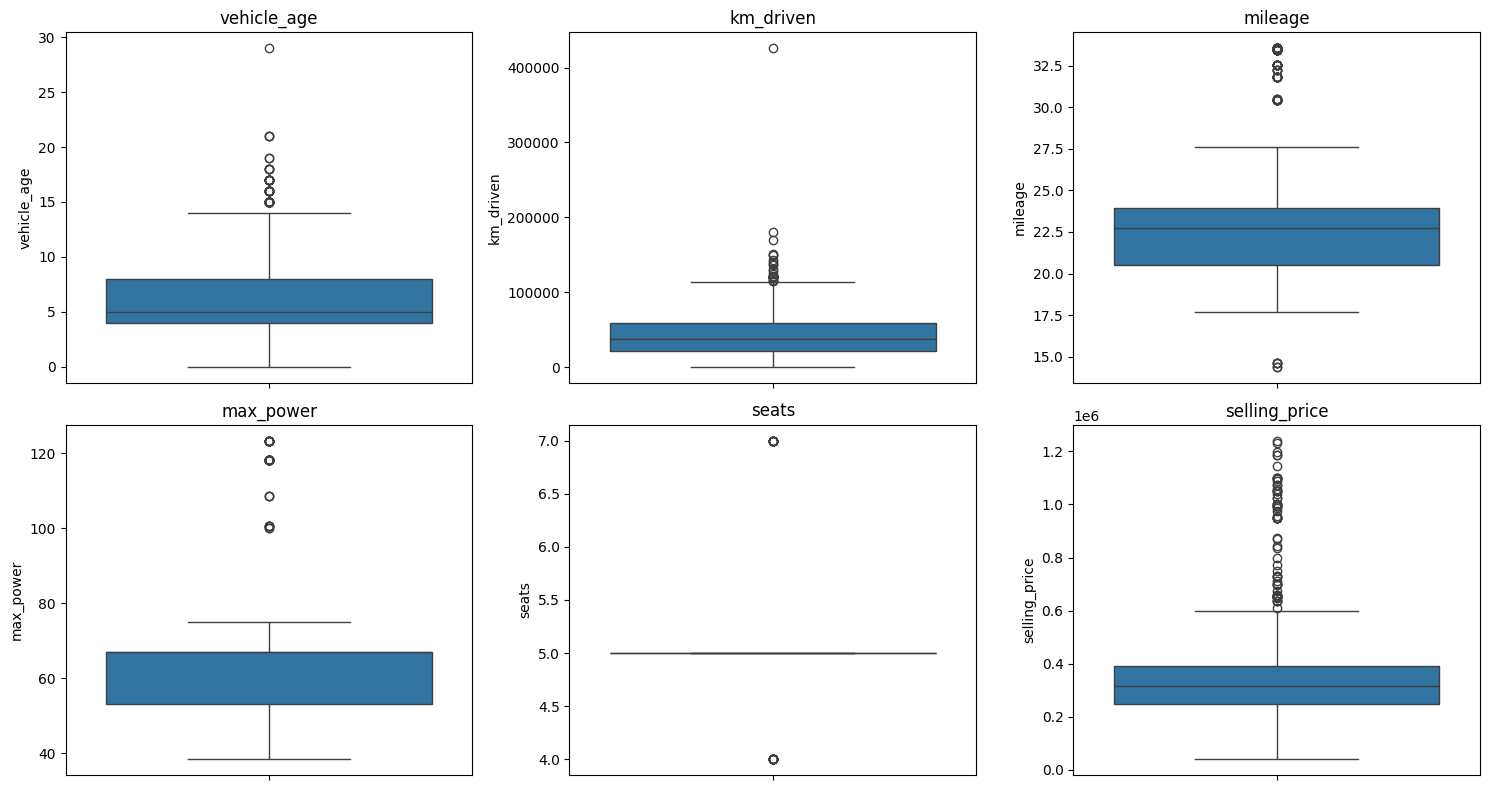


Outliers in vehicle_age: 73 (3.45%)

Outliers in km_driven: 41 (1.93%)

Outliers in mileage: 94 (4.44%)

Outliers in max_power: 62 (2.93%)

Outliers in seats: 30 (1.42%)

Outliers in selling_price: 70 (3.30%)


In [8]:
# Select numerical columns
numerical_cols = ['vehicle_age', 'km_driven', 'mileage', 'max_power', 'seats', 'selling_price']

# Visualize outliers using boxplots
plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

# Calculate IQR for each numerical column
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"\nOutliers in {col}: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")

# Decision on handling outliers:
# For this analysis, we'll cap the outliers rather than remove them
# to preserve data points, especially since selling price is our target

# Capping outliers
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Cap the values
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

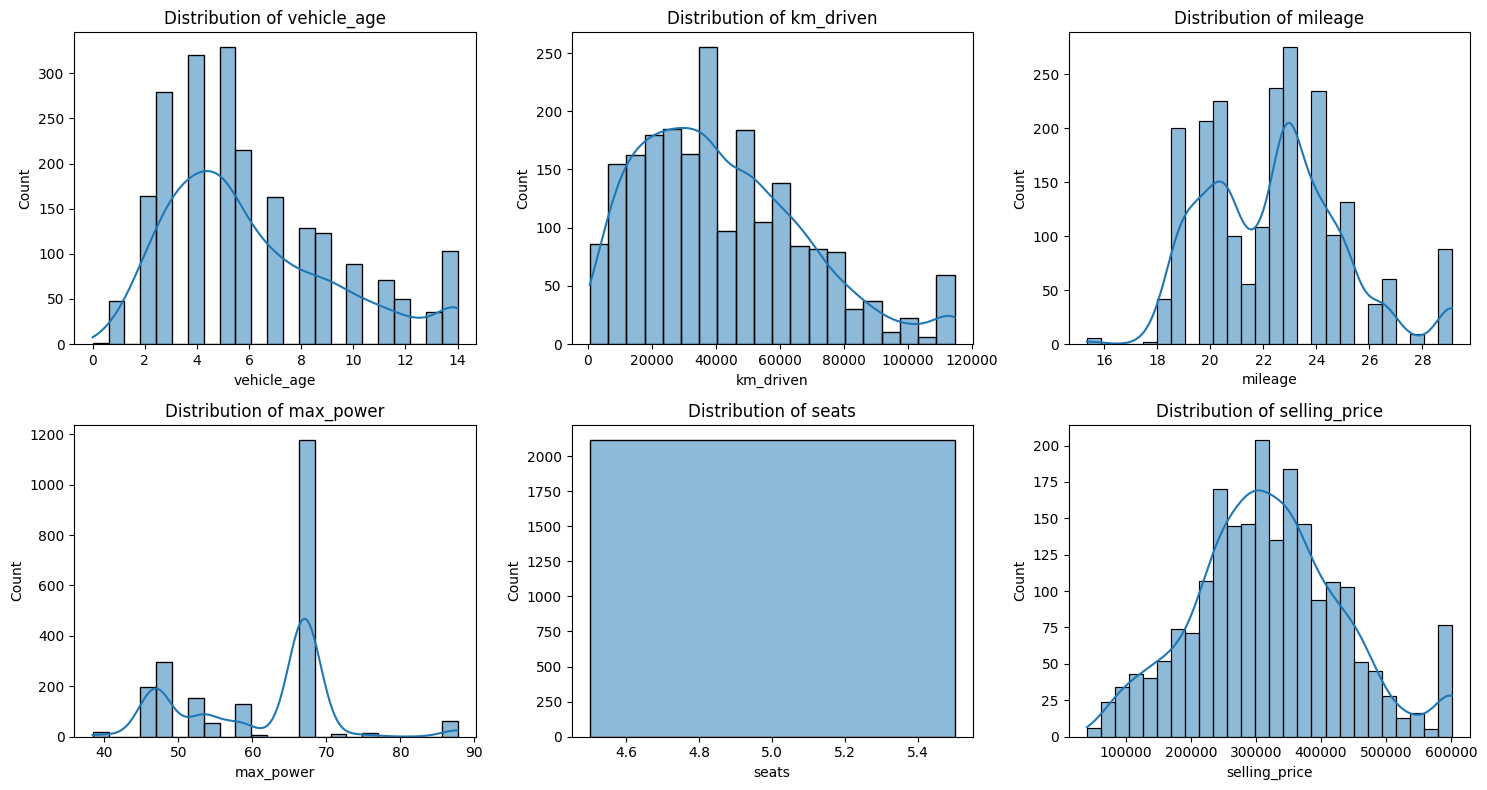


Skewness of numerical features:
vehicle_age      0.818305
km_driven        0.747835
mileage          0.483365
max_power       -0.056116
seats            0.000000
selling_price    0.255472
dtype: float64


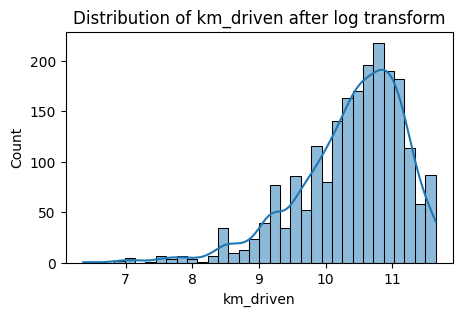

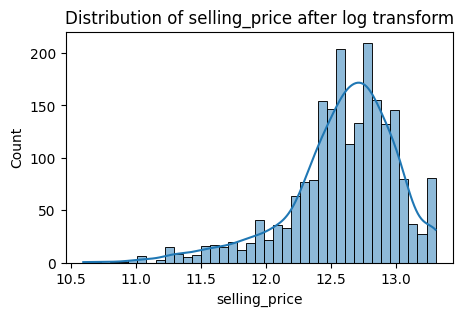

In [9]:
# Plot histograms for numerical columns
plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Calculate skewness
print("\nSkewness of numerical features:")
print(df[numerical_cols].skew())

# Apply log transformation to highly skewed features
skewed_cols = ['km_driven', 'selling_price']  # Based on skewness values

for col in skewed_cols:
    df[col] = np.log1p(df[col])  # Using log1p to handle zeros
    
    # Plot after transformation
    plt.figure(figsize=(5, 3))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col} after log transform')
    plt.show()

In [10]:
# Initialize scaler (using StandardScaler for this example)
scaler = StandardScaler()

# Scale numerical features (excluding target if it's in the list)
features_to_scale = [col for col in numerical_cols if col != 'selling_price']
df_scaled = df.copy()
df_scaled[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# Verify scaling
print("\nScaled features summary statistics:")
print(df_scaled[features_to_scale].describe().round(2))


Scaled features summary statistics:
       vehicle_age  km_driven  mileage  max_power   seats
count      2119.00    2119.00  2119.00    2119.00  2119.0
mean          0.00       0.00     0.00       0.00     0.0
std           1.00       1.00     1.00       1.00     0.0
min          -1.84      -5.07    -2.74      -2.26     0.0
25%          -0.63      -0.56    -0.75      -0.77     0.0
50%          -0.33       0.19     0.12       0.61     0.0
75%           0.58       0.73     0.58       0.61     0.0
max           2.40       1.58     2.58       2.68     0.0


In [11]:
# Identify categorical columns
categorical_cols = ['brand', 'model']  # 'car_name' is too granular and likely redundant

# Perform one-hot encoding
df_encoded = pd.get_dummies(df_scaled, columns=categorical_cols, drop_first=True)

# Alternative: Label encoding for ordinal categories
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# for col in categorical_cols:
#     df[col] = le.fit_transform(df[col])

print("\nAfter encoding categorical variables:")
print(df_encoded.head())


After encoding categorical variables:
         car_name  vehicle_age  km_driven   mileage  max_power  seats  \
0     Maruti Alto     0.886237   1.580313 -1.058542  -1.466541    0.0   
1     Maruti Alto     0.886237   0.155866 -0.587296   0.617189    0.0   
2  Maruti Wagon R     0.583100   0.085922 -1.367556   0.617189    0.0   
3  Maruti Wagon R    -0.932587  -0.785637 -0.745665   0.611179    0.0   
4   Hyundai Venue    -1.235725  -0.618434 -1.657256   2.684390    0.0   

   selling_price  brand_Ford  brand_Hyundai  brand_Maruti  ...  \
0      11.695255       False          False          True  ...   
1      12.328295       False          False          True  ...   
2      12.765691       False          False          True  ...   
3      12.923915       False          False          True  ...   
4      13.307183       False           True         False  ...   

   model_Ecosport  model_KWID  model_Polo  model_RediGO  model_S-Presso  \
0           False       False       False         

In [12]:
# Separate features and target
X = df_encoded.drop(['car_name', 'selling_price'], axis=1)  # Dropping car_name as it's too specific
y = df_encoded['selling_price']

# Feature selection using SelectKBest
selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X, y)

# Get scores and p-values
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Score': selector.scores_,
    'P-value': selector.pvalues_
}).sort_values('Score', ascending=False)

print("\nFeature importance scores:")
print(feature_scores)

# Select top features (for example, top 5)
top_features = feature_scores.head(5)['Feature'].tolist()
print("\nSelected top features:", top_features)

# Create new dataframe with selected features
df_final = df_encoded[top_features + ['selling_price']].copy()


Feature importance scores:
             Feature        Score        P-value
0        vehicle_age  4042.095603   0.000000e+00
3          max_power   783.417290  6.078750e-147
1          km_driven   474.835165   3.791144e-95
11     model_Celerio   235.453904   1.808976e-50
7       brand_Maruti   138.324906   5.569030e-31
6      brand_Hyundai   120.880486   2.200044e-27
19       model_Venue   120.880486   2.200044e-27
2            mileage    96.807656   2.286817e-22
8      brand_Renault    49.710327   2.402715e-12
9   brand_Volkswagen    41.367814   1.554434e-10
14        model_Polo    38.381049   6.972567e-10
5         brand_Ford    36.124271   2.174085e-09
12    model_Ecosport    36.124271   2.174085e-09
13        model_KWID    35.016423   3.803503e-09
17      model_Triber    32.722263   1.214031e-08
10      model_Baleno    15.947404   6.734963e-05
16    model_S-Presso    14.797041   1.232637e-04
18       model_Vento     2.883394   8.964414e-02
15      model_RediGO     2.315971   1.282

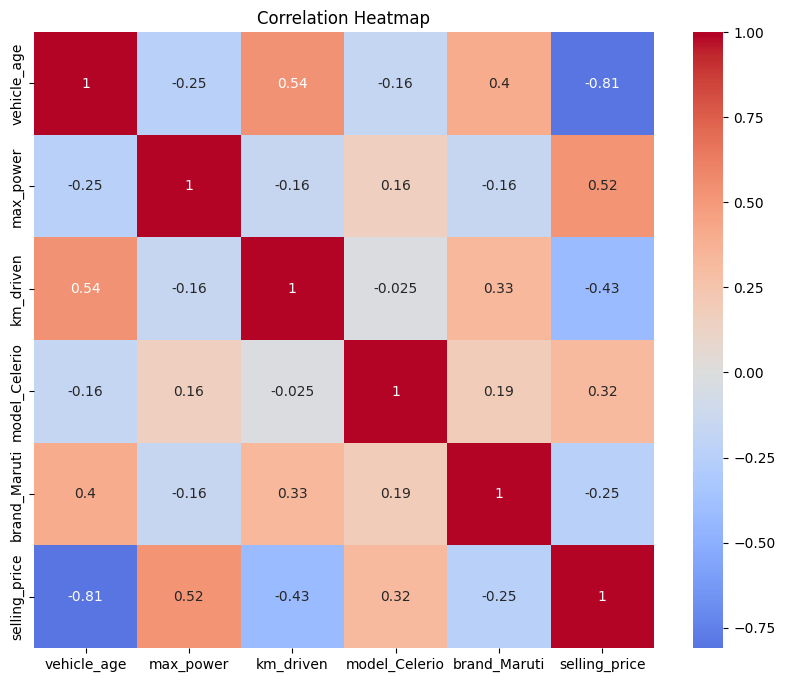

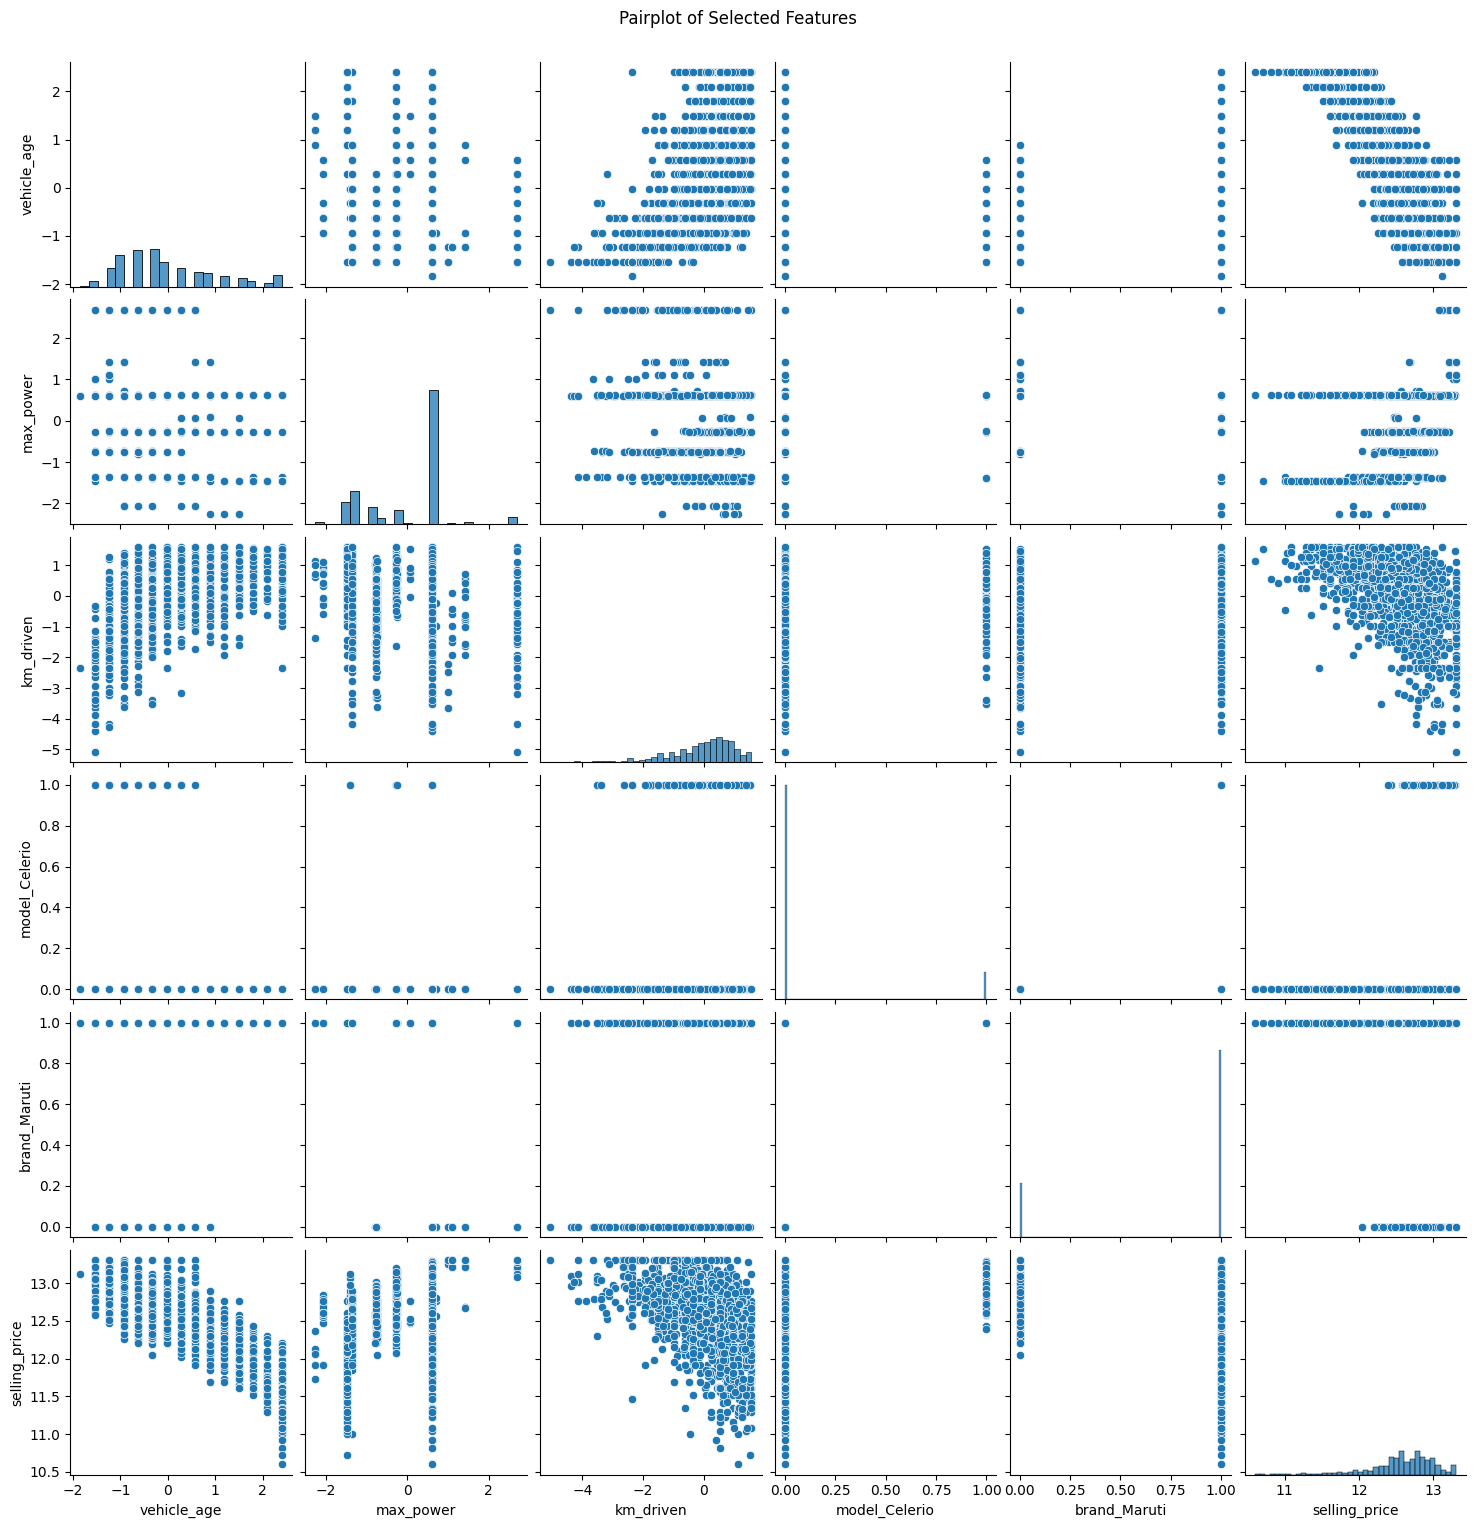

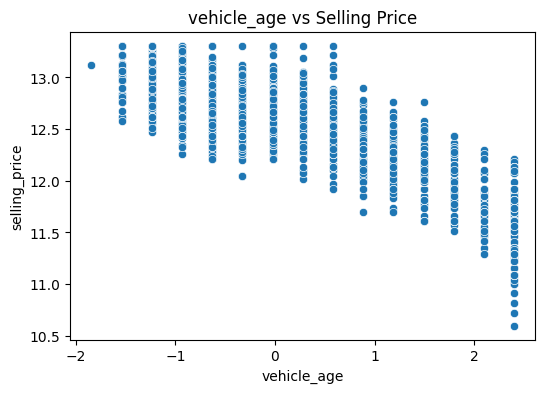

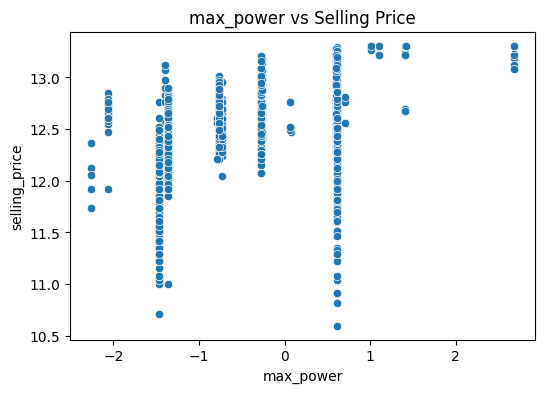

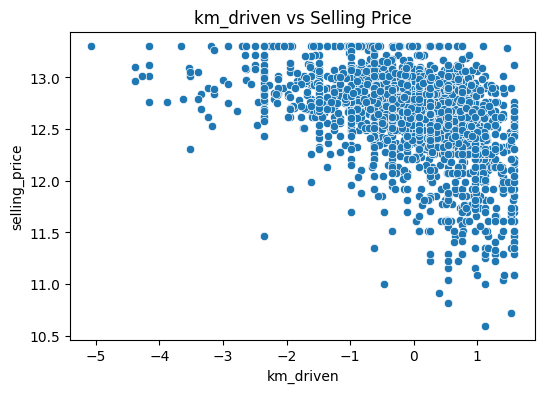

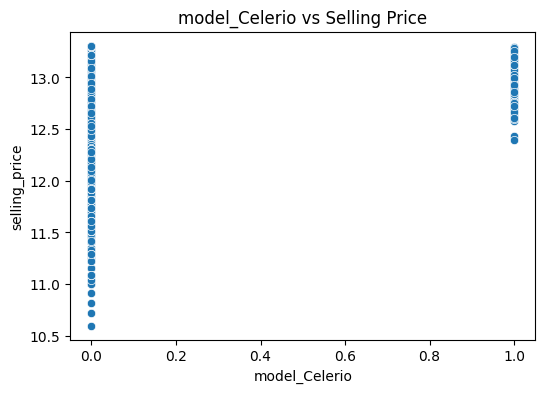

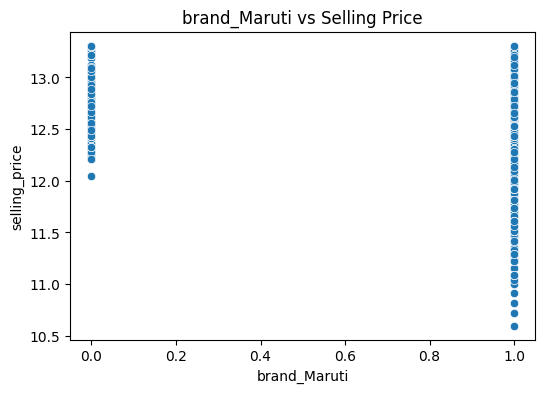

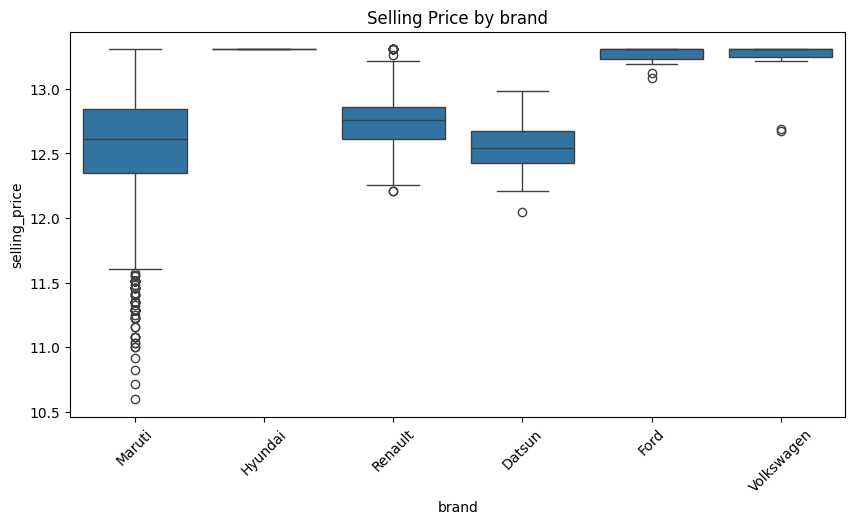

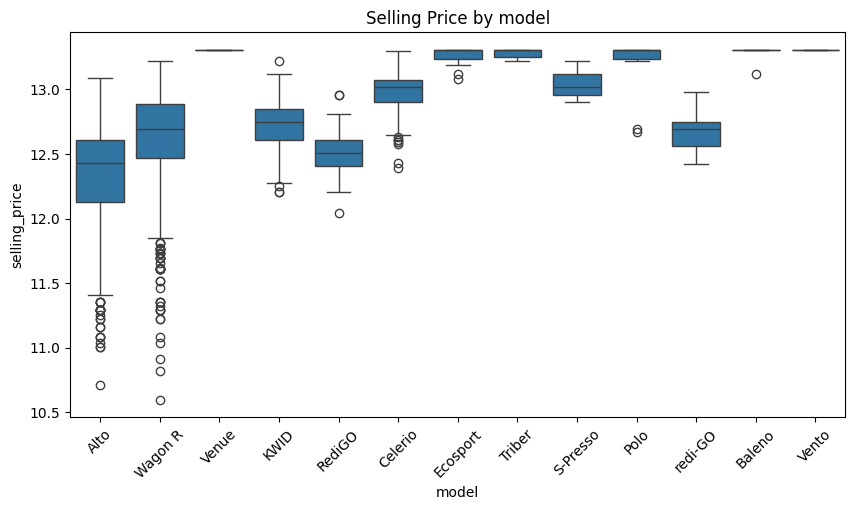

In [13]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
corr_matrix = df_final.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

# Pairplot of selected features
sns.pairplot(df_final)
plt.suptitle('Pairplot of Selected Features', y=1.02)
plt.show()

# Scatter plot of important features vs target
for feature in top_features:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df_final[feature], y=df_final['selling_price'])
    plt.title(f'{feature} vs Selling Price')
    plt.show()

# Boxplot of categorical variables vs target (using original categorical cols)
for col in categorical_cols:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df[col], y=df['selling_price'])
    plt.title(f'Selling Price by {col}')
    plt.xticks(rotation=45)
    plt.show()